## Intelligent Audio and Music Analysis Assignment 3
## Tempo Estimation and Beat Tracking

In this assignment we will explore methods to estimate the tempo and find the beats of music stored as PCM audio.
The methods we will use are by no means the only way to do this, and also not the best way. But they are quite simple and intuitive, and also perform reasonably well, given how basic they are.

## Data

As in the last assignment, we will use the dataset stored in numpy arrays. So first, let's load the data from the numpy archives:


In [1]:
import numpy as np
import os

dataset_path = os.path.join(os.environ['HOME'], 'shared', 'data', 'assignment_3')
if os.path.exists('data.npz'):
    dataset_path = '.'

audio_sample_rate = 44100
spec_frame_rate = 100
spec_freq_bins = 40

audio_data = np.load(os.path.join(dataset_path, 'data.npz'), allow_pickle=True, mmap_mode='r')

tempo_data = np.load(os.path.join(dataset_path, 'tempo.npz'), allow_pickle=True, mmap_mode='r')
beat_data = np.load(os.path.join(dataset_path, 'beats.npz'), allow_pickle=True, mmap_mode='r')

print(audio_data.files)
print(tempo_data.files)
print(beat_data.files)

['names', 'audio', 'spectrograms']
['annotations', 'audio_idxs']
['annotations', 'audio_idxs']


In [2]:
example_idx = 109

In [3]:
# note that we have 'audio_idxs' with annotations: 
# beat and tempo annotations exist only for a subset of the audio files
# our example with audio_idx 109 is one that has both.
# find corresponding indices for annotations:
beats_example_idx = np.argwhere(beat_data['audio_idxs']==example_idx)[0][0]
tempo_example_idx = np.argwhere(tempo_data['audio_idxs']==example_idx)[0][0]

# get annotations from onset data archive:
example_tempo_ann = tempo_data['annotations'][tempo_example_idx]
example_beats_ann = beat_data['annotations'][beats_example_idx]

# get the correct audio related data from the audio archive:
example_audio_name = audio_data['names'][example_idx]
example_audio = audio_data['audio'][example_idx]
example_spectrogram = audio_data['spectrograms'][example_idx]

print(example_spectrogram.shape)

# we can also play the audio in this jupyter notebook
import IPython.display as ipd
print("audio for file '{}':".format(example_audio_name))
ipd.Audio(example_audio, rate=audio_sample_rate)

(1001, 40)
audio for file 'al_Albums-AnaBelen_Veneo-13(1.8-11.8)':


## Task 1: Estimate Tempo using the ACF of an ODF (10 Points)

The tempo of a piece of music is the average rate of quarter notes one would tap along with the music (like a metronom).
Usually this tempo is measured in beats per minutes (i.e. usually quarter notes per minute) or BPM.

A simple yet effective way to estimate the tempo of an audio file, is to use an onset detection function (ODF)
(we extracted the *spectral flux* ODF in assignment 2) and find periodicity patterns in it. 

In this assignment we will apply this method to estimate the tempo for the audio files in the dataset.
In order to detect the tempo i.e. the periodicity the ODF, the following procedure should be applied:

1. Compute the onset detection function (ODF).
2. Compute the autocorrelation function (ACF) of the ODF.
3. Calc BPM for lag at the maximum of the ACF.

### 1.1 ODF calculation

Since we already covered ODF calculation in assignment 2, we will use the *librosa* implementation of *spectral_flux* in this assignment.

In [4]:
pip install numba # this is a workaround

Note: you may need to restart the kernel to use updated packages.


In [5]:
from librosa.onset import onset_strength

def onset_detection_function(spectrogram):
    return onset_strength(S=spectrogram.T)

### 1.2 ACF calculation

We use the same definition of the autocorrelation function as in the lecture:

$$ r(\tau) = \sum^{N-\tau-1}_{t=0}d(t+\tau) \cdot d(t) $$

where $r(\tau)$ is the autocorrelation at lag $\tau$ and $d(t)$ is the function for which the autocorrelation should be
calculated. In our case that is the onset detection function.

#### 1.2.1 Frame Lag to BPM
We only need to calculate $r(\tau)$ for lags that correspond to the BPM range that we are interested in.
In order to calculate the number of frames for a lag that corresponds to a certain tempo, we need a function to map
from BPM to a delta time in frames:

$$ BPM = \frac{60 \cdot fr}{\Delta t} $$

where $fr$ is the frame rate of our spectrogram, and $\Delta t$ is the distance between two quarter note onsets in
frames. Since BPMs and $\Delta t$ are conveniently inversely proportional, the same conversion function can be used in
both directions:

$$ \Delta t = \frac{60 \cdot fr}{BPM} $$

In [6]:
def bpm_to_frames(bpm, frame_rate=spec_frame_rate):
    """
    Converts from BPM to delta time in frames

    Parameters
    ----------
    bpm : float
        The tempo in beats per minute
    frame_rate : int, optional
        The rate of frames per second
    Returns
    -------
    float
        Delta time between two beats with bpm beat rate, in frames at a frame rate frame_rate.
    """

    frames = None
    ### BEGIN SOLUTION
    frames = 60/bpm*frame_rate
    ### END SOLUTION
    return frames

frames_to_bpm = bpm_to_frames

In [7]:
# tests
assert bpm_to_frames(120, 1) == 0.5
assert bpm_to_frames(60, 100) == 100

### BEGIN HIDDEN TESTS
for test_bpm in range(1, 20):
    assert np.allclose(bpm_to_frames(test_bpm, 1), 60/test_bpm)
    assert np.allclose(bpm_to_frames(test_bpm, 25), 60/test_bpm*25)
### END HIDDEN TESTS
print('All tests successful!')

All tests successful!


#### 1.2.2. Implement Autocorrelation Function

Note for implementation: always use a minimum lag of 1 for tau, we are never interested in a lag `tau=0` since that is always 100% correlated. Also, we circumvent some division by 0 problems that way.
    
**Hint**: [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) is closely related to cross-correlation, which in turn is closely related to convolution.

In [8]:
DEFAULT_MIN_BPM = 60
DEFAULT_MAX_BPM = 180

In [9]:
def autocorrelation(odf, min_bpm=DEFAULT_MIN_BPM, max_bpm=DEFAULT_MAX_BPM):
    """
    Calculates the autocorrelation for signal odf
    
    Parameters
    ----------
    odf : ndarray
        The vector with values for which ACF should be calculated. In our case this will be an ODF.
    min_bpm : float
        Minimum BPM value which defines the maximum lag for which the ACF should be calculated for.
    max_bpm : float
        Maximum BPM value which defines the minimum lag for which the ACF should be calculated for.        
    Returns
    -------
    acf : ndarray
        vector with length max_lag-min_lag containing the ACF values.
    lag_to_bpm : list
        bpm values for each lag corresponding to the index of acf.
    """

    acf = None
    lag_to_bpm = []
    ### BEGIN SOLUTION
    odf_len = len(odf)
    min_lag = int(max(np.floor(bpm_to_frames(max_bpm)), 1))
    max_lag = int(min(np.ceil(bpm_to_frames(min_bpm)), odf_len))
    
    acf = np.correlate(odf, odf, mode='full')
    acf = acf[odf_len+min_lag-1:odf_len+max_lag-1]

    lag_to_bpm = [bpm_to_frames(lag) for lag in range(min_lag, max_lag)]
    ### END SOLUTION
    return acf, lag_to_bpm

In [10]:
# tests for ACF calculation

def test_mats(real, exp):
    assert len(real) == len(exp) and \
    np.allclose(real, exp), \
        "test failed: real {} expected {}".format(real, exp)
    
test_sig = np.zeros((100,))
# force to go from lag 0 to 6000 - this means full acf for our 100 samples test signal:
calc_res, lag_to_bpm = autocorrelation(test_sig, 1, 10000)
expc_res = np.zeros((100,))
# we always crop lag tau=0, so we expect the value for tau=0 to be missing
exp_res_trim = expc_res[1:]
assert len(lag_to_bpm) == 99
test_mats(calc_res, exp_res_trim)

test_idxs = np.arange(10, 100, 10)
test_sig[test_idxs] = 1.0
calc_res, _ = autocorrelation(test_sig, 1, 10000)
exp_res_idxs = np.arange(0, 100, 10)
exp_res_vals = np.arange(9, -1, -1)
expc_res[exp_res_idxs] = exp_res_vals
exp_res_trim = expc_res[1:]
test_mats(calc_res, exp_res_trim)

calc_res, _ = autocorrelation(test_sig, 80, 200)
expc_res = expc_res[30:75]
test_mats(calc_res, expc_res)

### BEGIN HIDDEN TESTS
assert all([bpm == bpm_to_frames(idx+1) for idx, bpm in enumerate(lag_to_bpm)])
test_sig = onset_detection_function(example_spectrogram)
calc_res, _ = autocorrelation(test_sig, 1, 10000)
expc_res = np.correlate(test_sig, test_sig, mode='full')
expc_res = expc_res[int(expc_res.size/2):]
exp_res_trim = expc_res[1:]
test_mats(calc_res, exp_res_trim)
### END HIDDEN TESTS
print('All tests successful!')

All tests successful!


#### 1.2.3 Plot ACF
For visualization purposes and better understanding, **plot the ACF** of our selected example from the beginning of the notebook `example_spectrogram`.
Also **plot the spectrogram and ODF with shared x-axes** alongside as we have done in previous assignments.
To be able to better see details, just **plot the first 5 seconds** of the example.
Label the x-axis of the ACF in BPMs!

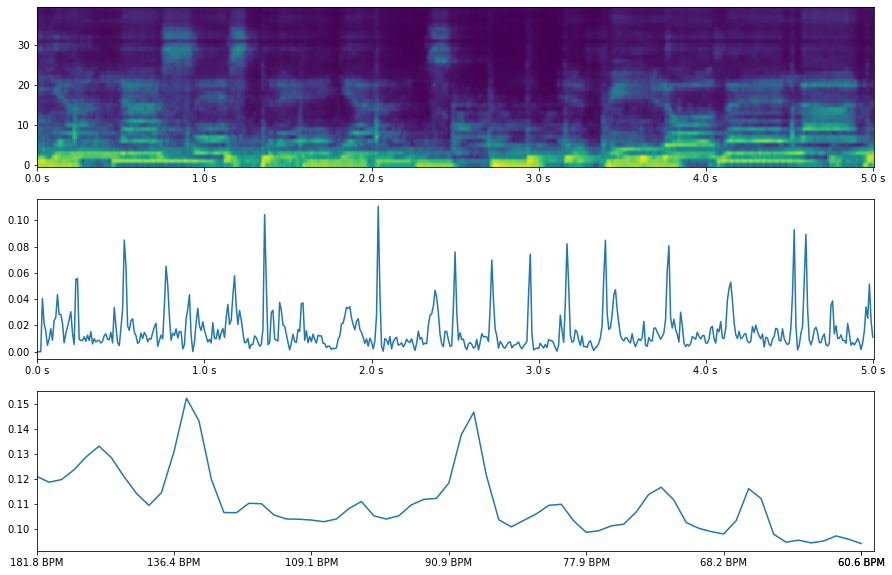

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

### BEGIN SOLUTION
example_spectrogram_snippet = example_spectrogram[:501]
example_odf = onset_detection_function(example_spectrogram_snippet)
example_acf, lag_to_bpm = autocorrelation(example_odf)

ax1=plt.subplot(3,1,1)
plt.imshow(example_spectrogram_snippet.T, origin='lower', aspect='auto')

plt.subplot(3,1,2, sharex=ax1)
plt.plot(example_odf)
xtick_pos = list(range(0, len(example_spectrogram_snippet), 100))
xtick_lab = ["{:.1f} s".format(x/spec_frame_rate) for x in xtick_pos]
plt.xticks(xtick_pos, xtick_lab)

plt.subplot(3,1,3)
plt.plot(example_acf)
plt.xlim((0, len(example_acf)))
xtick_pos = list(range(0, len(lag_to_bpm), 11))
xtick_pos.append(len(lag_to_bpm)-1)
xtick_lab = ["{:.1f} BPM".format(lag_to_bpm[x]) for x in xtick_pos]
plt.xticks(xtick_pos, xtick_lab)
### END SOLUTION
pass

### 1.3 Tempo Estimation Function

Now that we have all pieces to actually perform tempo detection, let's define the function to do so:

**Hint:** There exists a numpy function for getting the index of the maximum of an ndarray.

In [12]:
def estimate_tempo(spectrogram, **kwargs):
    """
    Calculcate tempo estimate for audiofile represented by input spectrogram.
    Parameters
    ----------
    spectrogram : ndarray
                Spectrogram of audio file under analysis.
    Returns
    -------
    float
        Tempo of audio file in BPM.
    """

    min_bpm = kwargs.get('min_bpm', DEFAULT_MIN_BPM)
    max_bpm = kwargs.get('max_bpm', DEFAULT_MAX_BPM)
    
    bpm = -1
    # 1. Calculate ODF
    # 2. Calculate ACF
    # 3. Find index of maximum in ACF
    # 4. Calculate BPM using peak index and bpm_for_lag array
    ### BEGIN SOLUTION
    odf = onset_detection_function(spectrogram)
    acf, bpm_for_lag = autocorrelation(odf, min_bpm, max_bpm)
    peak = np.argmax(acf)
    bpm = bpm_for_lag[peak]
    ### END SOLUTION
    return bpm

120.0
All tests successful!


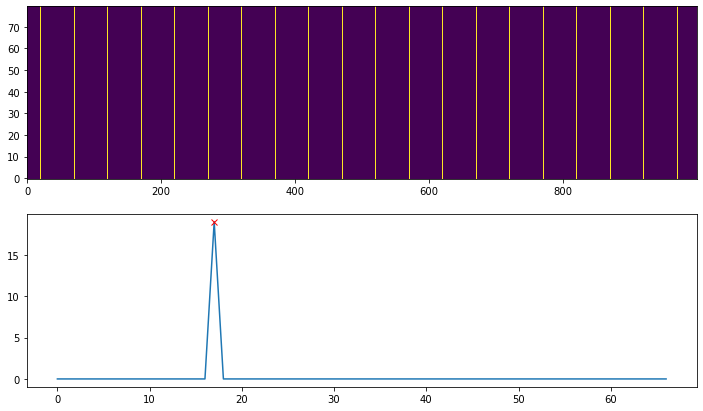

In [13]:
# tests

test_spec = np.zeros((1000, 80))
test_spec[20:1000:50, :] = 1
plt.figure(figsize=(12, 7))
print(estimate_tempo(test_spec))
assert estimate_tempo(test_spec) == 120

### BEGIN HIDDEN TESTS
plt.subplot(2,1,1)
plt.imshow(test_spec.T, origin='lower', aspect='auto', interpolation='none')
plt.subplot(2,1,2)
acf, bpm_for_lag = autocorrelation(onset_detection_function(test_spec), DEFAULT_MIN_BPM, DEFAULT_MAX_BPM)
plt.plot(acf)
peak = np.argmax(acf)
plt.plot(peak, acf[peak], 'xr')
### END HIDDEN TESTS
print('All tests successful!')

## Task 2: Predict Tempo on Data Set (3 Points)

Finally, let's do tempo estimation for all audio files in the data set.

In [14]:
# collect the spectrograms for files where we have tempo annotations...
tempo_specs = [audio_data['spectrograms'][idx] for idx in tempo_data['audio_idxs']]

In [15]:
def predict_tempo_for_all(spectrograms=tempo_specs, **kwargs):
    """
    Predict tempi for all files in dataset
    
    Parameters
    ----------
    spectrograms : list
        List of ndarrays which contain spectrograms for audio files.
    Returns
    -------
    list
        List of tempi for each audio file.
    """
    detected_tempi = []
    
    # iterate over spectrograms, estimate tempo, and put it in detected_tempi:
    # BEGIN SOLUTION
    for spectrogram in spectrograms:
        bpm = estimate_tempo(spectrogram, **kwargs)
        detected_tempi.append(bpm)
    # END SOLUTION
    return detected_tempi

In [16]:
# run tempo detection on dataset...
import time
t1=time.time()
detected_tempi = predict_tempo_for_all()
print("Time used for tempo detection: {:.1f} seconds.".format(time.time()-t1))

Time used for tempo detection: 0.2 seconds.


In [17]:
# tests

assert len(detected_tempi) == len(tempo_data['annotations'])

print('All tests successful!')

All tests successful!


## Task 3: Evaluation of Tempo Estimation (5 Points)

Evaluate the mean tempo estimation performance (e.g. with `madmom.evaluation.tempo` module) on the dataset. Use
`Accuracy 1` (with 4% tolerance) and `Accuracy 2` (allowing 4% tolerance, including double and half tempo variants) as metrics.

In [18]:
DEFAULT_TOLERANCE = 0.04

In [19]:
def evaluate_tempo(tempi, annotations, tolerance=DEFAULT_TOLERANCE):
    """
    Evaluate detected tempi against ground truth annotations.

    Parameters
    ----------
    tempi : list
        List with tempo detections for all files.
    annotations : list
        List with corresponding ground truth annotations.

    Returns
    -------
    accuracy_1 : float
        Averaged (macro) accuracy 1.
    accuracy_2 : float
        Averaged (macro) accuracy 2.

    """
    evals = []
    # iterate over detections and annotations, as we have done in assignment 2
    # calculate metrics for each track
    # return average metrics for all tracks
    ### BEGIN SOLUTION
    from madmom.evaluation.tempo import TempoEvaluation, TempoMeanEvaluation
    for det, ann in zip(tempi, annotations):
        e = TempoEvaluation(det, ann, tolerance=tolerance)
        evals.append(e)
    me = TempoMeanEvaluation(evals)
    accuracy_1 = me.acc1
    accuracy_2 = me.acc2
    ### END SOLUTION
    return accuracy_1, accuracy_2

In [20]:
# tests

test_mats(evaluate_tempo([120], [120], 0.04), 
          (1.0, 1.0))
test_mats(evaluate_tempo([120, 130], [120, 160], 0.04), 
          (0.5, 0.5))
test_mats(evaluate_tempo([120, 130], [124, 130], 0.04), 
          (1.0, 1.0))
test_mats(evaluate_tempo([120, 130], [126, 130], 0.10), 
          (1.0, 1.0))

### BEGIN HIDDEN TESTS
from madmom.evaluation.tempo import TempoEvaluation, TempoMeanEvaluation
tme = TempoMeanEvaluation([TempoEvaluation(det, ann, tolerance=0.04) for det, ann in zip(detected_tempi, tempo_data['annotations'])])
test_mats(evaluate_tempo(detected_tempi, tempo_data['annotations'], 0.04), (tme.acc1, tme.acc2))
### END HIDDEN TESTS
print('All tests successful!')

All tests successful!


/opt/conda/lib/python3.9/site-packages/madmom/evaluation/tempo.py:123: UserWarning: no annotated tempo strengths given, assuming a uniform distribution
  warnings.warn('no annotated tempo strengths given, assuming a uniform '


In [21]:
# evaluate against ground truth
acc1, acc2 = \
    evaluate_tempo(detected_tempi, tempo_data['annotations'])

print('Tempo estimation results\nAccuracy 1: {:.3f}\nAccuracy 2: {:.3f}'
      .format(acc1, acc2))

Tempo estimation results
Accuracy 1: 0.571
Accuracy 2: 0.864


With correct implementation and default values, you should be able to achieve at least 0.5 ACC1 and 0.8 ACC2.

In [22]:
# tests
assert acc1 > 0.5
assert acc2 > 0.8

print('All tests successful!')

All tests successful!


## Task 4: Beat Tracking (10 Points)

Finally we will apply a simple beat tracking technique discussed in the lecture, to identify beats for the audio
excerpts.
To detect the beats, the following procedure should be applied:

1. Determine the beat phase, given the tempo determined in task 3 and select the first beat.

2. Track beats based on the tempo; allow a fixed (default = ±10%) tempo deviation between consecutive beats.


### 4.1 First Beat
The beat phase tells us where the first beat has to be placed.
A simple way to detect the beat phase is to correlate a tempo puls train with the onset detection function.
The lag with the highest correlation is a good estimate for our beat phase (= position of first beat).

Implement a function that:
1. Creates a puls train from the provided tempo in BPM
2. Correlates the puls train with the provided ODF 
3. Return the index with the highest correlation value as beat phase

A main question is how long the puls train should be and how much of the ODF should be correlated with the pulse train.
For now, use the provided default parameters: First, `beat_interval` (distance between two beats) can be calculated using the tempo. `pulse_len` is a parameter that specifies the lenght of the tempo pulse train, and `corr_fac` defines for how many lags the pulse train should be correlated (as a factor of `beat_interval`).
Theoretically, the maximum lag for the phase should not exceed `beat_interval`, if the right tempo was detected. However, as you will see, correlating for more frames, i.e. more lags, can improve performance (double tempo errors, e.g.).


In [23]:
DEFAULT_PULSE_LEN = 4*spec_frame_rate
DEFAULT_CORR_FAC = 1

In [24]:
def find_beat_phase(odf, tempo, pulse_len=DEFAULT_PULSE_LEN, corr_fac=DEFAULT_CORR_FAC):
    """
    Finds the first beat by cross-correlation a pulse train.
    Parameters
    ----------
    odf : ndarray
        Onset density function.
    tempo : float
        Estimated tempo in BPM, used to create pulse train.
    pulse_len : int
        Length of pulse train, in frames.
    corr_fac : float
        Factor for beat_interval (from tempo) which defines for how many frames cross-correlation should be done.
    Returns
    -------
    int
        Beat phase in frames.
    """
    phase = 0
    
    # this is the beat intervall in frames, given our tempo hypothesis.
    beat_interval = int(np.round(bpm_to_frames(tempo)))
    # this is the number of lags we should correlate the ODF with. 
    # Output phase will be in the intervall [0..num_corr_lags]
    num_corr_lags = int(np.round(beat_interval*corr_fac))

    # 1) create pulse train with length pulse_len, all zeros, set positions with pulses to 1
    # 2) get appropriate part of ODF to correlate with (right length!)
    # 3) cross-correlate the two
    # 4) use index with max as phase
    ### BEGIN SOLUTION
    odf_len = len(odf)
    odf_min_len = pulse_len + num_corr_lags
    
    # create pulse train:
    phase_corr = np.zeros((pulse_len, ))  # (phase_frames, ))
    pulse_idx = np.arange(0, pulse_len, beat_interval, dtype=np.int)
    phase_corr[pulse_idx] = 1
    
    phase_lags = np.correlate(odf[:odf_min_len], phase_corr, mode='valid')
    
    phase = np.argmax(phase_lags)
    ### END SOLUTION
    return phase

In [25]:
# tests

test_odf = np.zeros((300, ))
test_odf[5] = 1
assert find_beat_phase(test_odf, 60) == 5

test_odf[20] = 1
test_odf[120] = 1
test_odf[125] = 1
test_odf[225] = 1
assert find_beat_phase(test_odf, 60) == 20

print('All tests successful!')

All tests successful!


### 4.2 Beat Tracking Function
The next function should detect all peaks sequentially (greedily) using tempo, beat phase, and detected onsets.
1. Start at the first beat, which is indicated by the beat phase.
2. Check if an onset is closer then the step size multiplied with `tolerance`. <br>
3. If this is the case, use the onset as new beat location and update tempo, use `tempo_change_fac` as a scaling factor to update the tempo / step size.<br>
4. If not, just use the predicted position
5. Use the tempo to go to next estimated beat position
6. Repeat until no more onsets are available

In [26]:
DEFAULT_TOLERANCE = 0.1  # 10%
DEFAULT_TEMPO_CHANGE_FAC = 0.5  # only use 50% of difference for tempo update...

In [27]:
def track_beats(onsets, tempo, phase, tolerance=DEFAULT_TOLERANCE, 
                tempo_change_fac=DEFAULT_TEMPO_CHANGE_FAC):
    """
    Tracks beat using onsetes, tempo, phase.
    Parameters
    ----------
    onsets : list
        List of onset times in frames (integers).
    tempo : float
        Tempo in BPM
    phase : int
        Beat phase (potential position of first beat) in frames.
    tolerance : float
        Maximum tolerance for onset position, as factor of beat intervall.
    tempo_change_fac : 
        Actual differences in intervalls will be downscaled by this factor, before updating tempo/beat intervall.

    Returns
    -------
    ndarray
        Array with detected beat positions.
    """
    beats = []
    # beat intervall
    beat_interval = bpm_to_frames(tempo)
    # +-window to find onset at estimated beat position, i.e. distance to onset must be <= max_diff
    max_diff = int(np.ceil(beat_interval*tolerance))

    # start at phase
    # 1) try to find on onset at current position +- max_diff
    # 2) if so -> use onset as beat position, if not, use current position (add beat to beats)
    # 3) if onset was found, update beat_interval by scaling actuall difference with tempo_change_fac
    # 4) don't forget to also update max_diff with new beat_interval!
    # 5) move current position forward by beat_interval 
    # 6) repeat from 1) until cur position > then max position in onsets
    
    ### BEGIN SOLUTION
    cur_frame = phase-beat_interval
    
    while (cur_frame) <= np.max(onsets):
        # print ('{}--{}'.format(cur_frame, np.max(onsets)))
        next_frame = cur_frame + beat_interval
        
        distances = np.abs(onsets - next_frame)
        candidate = np.argmin(distances)
        if distances[candidate] < max_diff:
            next_frame = onsets[candidate]
            # update tempo and max change
            delta_diff = next_frame-cur_frame - beat_interval
            delta_new = beat_interval + delta_diff*tempo_change_fac
            # print("update: (d:{} + n:{}  - c:{}) / 2 = {}".format(delta_time, next_frame, cur_frame, delta_new))
            beat_interval = delta_new
            max_diff = beat_interval*tolerance
            # print("nmxch:{}".format(max_change))

        cur_frame = next_frame
        beats.append(cur_frame)
    
    ### END SOLUTION
    return np.asarray(beats)


In [28]:
# tests

test_onsets = np.asarray([40, 90, 140, 190, 243, 296, 344, 391, 430], dtype=np.float)
beats = track_beats(test_onsets, 120, 40)
test_onsets[-1] = 439.5625

test_mats(beats, test_onsets)

print('All tests successful!')

All tests successful!


### 4.3 Track Beats on Dataset
Finally, since we have all the parts necessary, let's **implement the function** to detect the beats for a track.

In [29]:
def predict_beats(spectrogram, **kwargs):
    # get kwargs for tempo:
    min_bpm = kwargs.get('min_bpm', DEFAULT_MIN_BPM)
    max_bpm = kwargs.get('max_bpm', DEFAULT_MAX_BPM)
    # get kwargs for onsets:
    onset_thresh = kwargs.get('onset_thresh', 0.2)
    # get kwargs for phase:
    corr_fac = kwargs.get('corr_fac', DEFAULT_CORR_FAC)
    pulse_len = kwargs.get('pulse_len', DEFAULT_PULSE_LEN)
    # get kwargs for tracking:
    tolerance = kwargs.get('tolerance', DEFAULT_TOLERANCE)
    tempo_change_fac = kwargs.get('tempo_change_fac', DEFAULT_TEMPO_CHANGE_FAC)
    
    # use our tempo estimation to get the bpm
    bpm = estimate_tempo(spectrogram, min_bpm=min_bpm, max_bpm=max_bpm)

    # onset detection - we want to be conservative here, to get high precision!
    # we use the madmom stuff for simplicity here
    from madmom.features.onsets import peak_picking, combine_events
    ce_delta = 3
    odf = onset_detection_function(spectrogram)
    peak_candidates = peak_picking(odf/odf.max(), onset_thresh)
    onsets = np.asarray(combine_events(peak_candidates, ce_delta, 'left'), dtype=np.int)

    beats = []
    # NOTE: use the parameters extracted from the kwargs for find_beat_phase and track_beats!!
    # track beats:
    # 1) find beat phase
    # 2) track beats
    # 3) convert from frames to seconds
    ### BEGIN SOLUTION
    # get phase
    phase = find_beat_phase(odf, bpm, corr_fac=corr_fac, pulse_len=pulse_len)

    # track beats
    beats = track_beats(onsets, bpm, phase, tolerance=tolerance, tempo_change_fac=tempo_change_fac)
    beats = beats/spec_frame_rate
    ### END SOLUTION
    return beats

Get all audio files with beat annotations, and run beat tracking for all of them:

In [30]:
beat_specs = [audio_data['spectrograms'][idx] for idx in beat_data['audio_idxs']]

In [31]:
def predict_beats_for_all(spectrograms=beat_specs, **kwargs):
    # list for collecting the onset detections, sorted in the same way
    detected_beats = []
    for idx, spectrogram in enumerate(spectrograms):
        detected_beats.append(predict_beats(spectrogram, **kwargs))
    return detected_beats

detected_beats = predict_beats_for_all()

In [32]:
# tests

assert len(detected_beats) == len(beat_data['annotations'])

print('All tests successful!')

All tests successful!


## Task 5: Evaluate Beat Tracking (5 Points)

Evaluate beat tracking performance using the `madmom.evaluation.beats` module on the dataset. Use `fmeasure`, `CMLt`,  and `AMLt` as evaluation metrics. For parameters, go with defaults.

Additionally, calculate a mean phase accuracy - check if the detected first beat is within `phase_tol` to any annotation, to see how well our phase detection is performing.
If the phase (first beat in detections) correlates with a beat in annotations, add 1, else add 0, and divide by the number of tracks in the end.

In [33]:
def evaluate_beats(beats, annotations, phase_tol=0.05):
    """
    Evaluate detected beats against ground truth annotations.

    Parameters
    ----------
    beats : list
        List with beats detections for all files.
    annotations : list
        List with corresponding ground truth annotations.
    phase_tol : float
        Tolerance for phase (first beat) to be accepted as correct, in seconds.

    Returns
    -------
    cmlt : float
        Averaged CMLt.
    amlt : float
        Averaged AMLt.
    fmeasure : float
        Averaged f-measure.
    phase_acc : float
        Averaged phase accuracy.

    """
    evals = []
    phase_acc = 0
    # iterate over detections and annotations, as we have done in assignment 2
    # calculate metrics for each track
    # return average metrics for all tracks
    ### BEGIN SOLUTION
    from madmom.evaluation.beats import BeatEvaluation, BeatMeanEvaluation
    for det, ann in zip(beats, annotations):
        e = BeatEvaluation(det, ann, information_gain_bins=2)
        evals.append(e)
        if len(ann) < 1:
            phase_acc+=1 
        elif len(det) > 1 and np.min(np.abs(np.asarray(ann)-det[0])) <= phase_tol:
            phase_acc+=1

    me = BeatMeanEvaluation(evals)
    cmlt = me.cmlt
    amlt = me.amlt
    fmeasure = me.fmeasure
    phase_acc = phase_acc / len(annotations)
    ### END SOLUTION
    return cmlt, amlt, fmeasure, phase_acc

In [34]:
# tests

test_mats(evaluate_beats([[]], [[]], 0.05), 
          (1.0, 1.0, 1.0, 1.0))
test_mats(evaluate_beats([[1.0, 2.0]], [[1.0, 2.0]], 0.05), 
          (1.0, 1.0, 1.0, 1.0))
test_mats(evaluate_beats([[1.00, 3.5]], [[1.049, 3.55]], 0.05), 
          (1.0, 1.0, 1.0, 1.0))
test_mats(evaluate_beats([[0.02, 3.5]], [[0.04, 3.55]], 0.1), 
          (1.0, 1.0, 1.0, 1.0))

### BEGIN HIDDEN TESTS
annotations = beat_data['annotations']
from madmom.evaluation.beats import BeatEvaluation, BeatMeanEvaluation
bme = BeatMeanEvaluation([BeatEvaluation(det, ann, information_gain_bins=2) 
                          for det, ann in zip(detected_beats, annotations)])

phase_acc = 0 
phase_tol = 0.05
for det, ann in zip(detected_beats, annotations):
    if len(ann) < 1:
            phase_acc+=1 
    elif len(det) > 1 and np.min(np.abs(ann-det[0])) <= phase_tol:
        phase_acc+=1
phase_acc = phase_acc / len(annotations)
test_mats(evaluate_beats(detected_beats, annotations, phase_tol), 
          (bme.cmlt, bme.amlt, bme.fmeasure, phase_acc))
### END HIDDEN TESTS
print('All tests successful!')

All tests successful!


In [35]:
# evaluate against ground truth
cmlt, amlt, fmeasure, phacc =\
    evaluate_beats(detected_beats, beat_data['annotations'])

print('Beat tracking results\ncmlt:      {:.3f}\n' \
      'amlt:      {:.3f}\n-----------------\n' \
      'fmeasure:  {:.3f}\nphase acc: {:.3f}\n'
      .format(cmlt, amlt, fmeasure, phacc))

Beat tracking results
cmlt:      0.358
amlt:      0.651
-----------------
fmeasure:  0.532
phase acc: 0.633



With correct implementation and default values, you should be able to achieve the performance values below:

In [36]:
# tests

assert cmlt > 0.2
assert amlt > 0.4
assert fmeasure > 0.4
assert phacc > 0.5

print('All tests successful!')

All tests successful!


## Task 6: Optimize Beat Tracking Results (4 Points)

Optimize the parameters to get the best performance on the dataset.
Parameters to be optimised: see list below in comment.

Use the kwargs in `predict_beats_for_all` and forward them to the subroutines.

In [37]:
# detected_beats_o = predict_beats_for_all(min_bpm=DEFAULT_MIN_BPM, 
#                                         max_bpm=DEFAULT_MAX_BPM,
#                                         onset_thresh=0.2,
#                                         pulse_len=DEFAULT_PULSE_LEN,
#                                         corr_fac=DEFAULT_CORR_FAC,
#                                         tolerance=DEFAULT_TOLERANCE,
#                                         tempo_change_fac = DEFAULT_TEMPO_CHANGE_FAC)

### BEGIN SOLUTION
detected_beats_o = predict_beats_for_all(min_bpm=80, 
                                         max_bpm=180,
                                         onset_thresh=0.4,
                                         pulse_len=2*spec_frame_rate,
                                         corr_fac=5,
                                         tolerance=0.1,
                                         tempo_change_fac = 0.2)
### END SOLUTION

cmlt_o, amlt_o, fmeasure_o, phacc_o = \
    evaluate_beats(detected_beats_o, beat_data['annotations'])

print('Beat tracking results\ncmlt:      {:.3f}\n' \
      'amlt:      {:.3f}\n-----------------\n' \
      'fmeasure:  {:.3f}\nphase acc: {:.3f}\n'
      .format(cmlt_o, amlt_o, fmeasure_o, phacc_o))


Beat tracking results
cmlt:      0.433
amlt:      0.681
-----------------
fmeasure:  0.594
phase acc: 0.746



With optimized values, you should be able to achieve the performance values below:

In [38]:
# tests

assert cmlt_o > 0.4
assert amlt_o > 0.6
assert fmeasure_o > 0.5
assert phacc_o > 0.6

print('All tests successful!')

All tests successful!


## Task 7: Discussion (8 Points)

### 7.1 Visualize Results
Take the example from the very beginning and produce some well formatted plots that show:
1. Audio signal
2. Spectrogram
3. ACF and peak
4. Beats and annotations over ODF

For plots for 1, 2, and 4, align the time axis!

ann tempo:      104.0
beat ann tempo: 104.21763790412263
det tempo:      105.26315789473684
beat det tempo: 104.41969104765899
Beat tracking results
cmlt:      0.947
amlt:      0.947
-----------------
fmeasure:  0.973
phase acc: 1.000



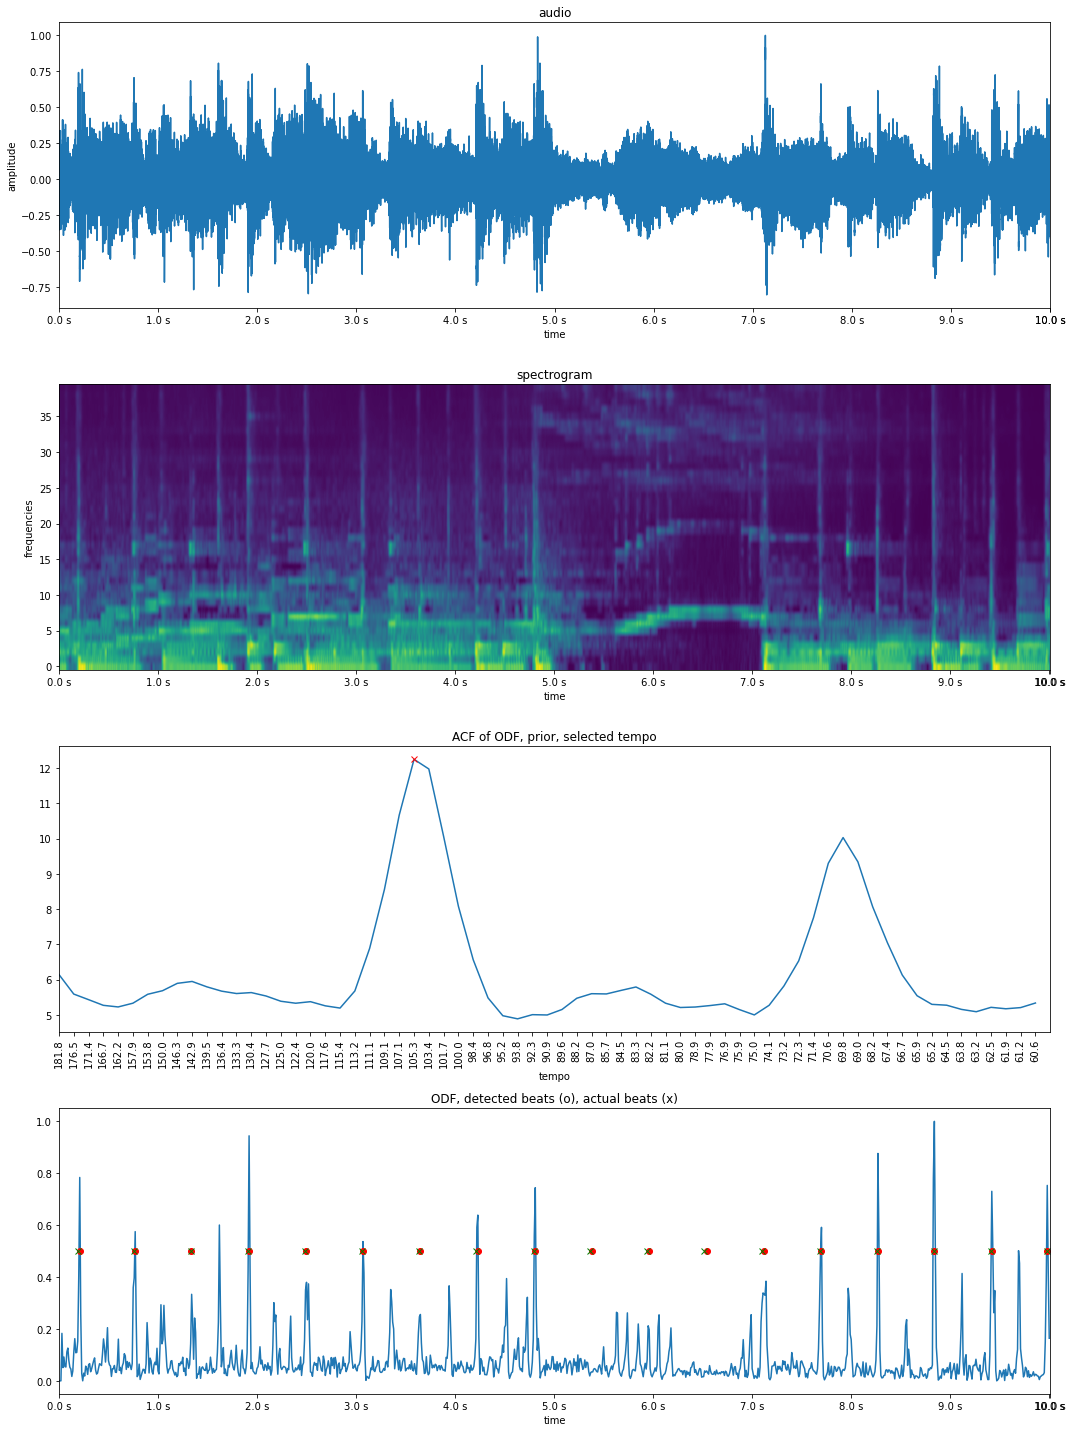

In [39]:
import matplotlib.pyplot as plt

### BEGIN SOLUTION

example_idx = 155
beats_example_idx = np.argwhere(beat_data['audio_idxs']==example_idx)[0][0]
tempo_example_idx = np.argwhere(tempo_data['audio_idxs']==example_idx)[0][0]

# get annotations from onset data archive:
example_tempo_ann = tempo_data['annotations'][tempo_example_idx]
example_beats_ann = beat_data['annotations'][beats_example_idx]

# get the correct audio related data from the audio archive:
example_audio_name = audio_data['names'][example_idx]
example_audio = audio_data['audio'][example_idx]
example_spectrogram = audio_data['spectrograms'][example_idx]


plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
plt.plot(example_audio/example_audio.max())
plt.xlim(0, len(example_audio))
tickpos = list(range(0, example_audio.shape[0], audio_sample_rate))
tickpos.append(example_audio.shape[0])
ticklab = ["{:.1f} s".format(idx/audio_sample_rate) for idx in tickpos]
plt.xticks(tickpos, ticklab)
plt.title("audio")
plt.xlabel("time")
plt.ylabel("amplitude")

ax2 = plt.subplot(4,1,2)
plt.imshow(example_spectrogram.T, origin='lower', aspect='auto')
tickpos = list(range(0, example_spectrogram.shape[0], spec_frame_rate))
tickpos.append(example_spectrogram.shape[0])
ticklab = ["{:.1f} s".format(idx/spec_frame_rate) for idx in tickpos]
plt.xticks(tickpos, ticklab)
plt.title("spectrogram")
plt.ylabel("frequencies")
plt.xlabel("time")

plt.subplot(4,1,4, sharex=ax2)
example_odf = onset_detection_function(example_spectrogram)
example_odf = example_odf/example_odf.max()
plt.plot(example_odf)
plt.xlim(0, len(example_spectrogram))

example_beat_detections = detected_beats_o[beats_example_idx]
example_beat_annotations = beat_data['annotations'][beats_example_idx]
plt.plot(np.asarray(example_beat_detections)*spec_frame_rate, np.ones((len(example_beat_detections), ))*0.5, 'ro')
plt.plot(np.asarray(example_beat_annotations)*spec_frame_rate, np.ones((len(example_beat_annotations), ))*0.5, 'gx')
plt.title("ODF, detected beats (o), actual beats (x)")
plt.xlabel("time")


print('ann tempo:      {}'.format(tempo_data['annotations'][tempo_example_idx]))
print('beat ann tempo: {}'.format(60/np.mean(np.diff(example_beat_annotations))))
print('det tempo:      {}'.format(detected_tempi[tempo_example_idx]))
print('beat det tempo: {}'.format(60/np.mean(np.diff(example_beat_detections))))
cmlt_t, amlt_t, fmeasure_t, phacc_t = \
    evaluate_beats([example_beat_detections], [example_beat_annotations])

print('==================\nBeat tracking results\ncmlt:      {:.3f}\namlt:      {:.3f}\n-----------------\nfmeasure:  {:.3f}\nphase acc: {:.3f}\n'
      .format(cmlt_t, amlt_t, fmeasure_t, phacc_t))

plt.subplot(4,1,3)
example_acf, lag_to_bpm = autocorrelation(example_odf, min_bpm=DEFAULT_MIN_BPM, max_bpm=DEFAULT_MAX_BPM)
example_peak = np.argmax(example_acf)
plt.plot(example_acf)
plt.plot(example_peak, example_acf[example_peak], 'xr')
plt.xlim(0, len(example_acf))
plt.title("ACF of ODF, prior, selected tempo")
plt.xlabel("tempo")
tickpos = range(0, len(lag_to_bpm))
ticklab = ["{:.1f}".format(lag_to_bpm[idx]) for idx in tickpos]
plt.xticks(tickpos, ticklab, rotation='90')

plt.tight_layout()

pass
### END SOLUTION

### 7.2 Conclusion

Summarize your findings and experiences:
What parts did you find to be most difficult to implement?
Do your tempo estimation and beat tracking system perform as well as you imagined before you started?
What do you think are the main weaknesses of the implemented systems?
What were the main difficulties during parameter optimization?

YOUR ANSWER HERE